Create a data generator 

In [7]:
from keras.preprocessing.image import ImageDataGenerator
import os

folderName = 'transfer data 0.1'

trainDir = folderName + '/movie_train'
validDir = folderName + '/movie_valid'
testDir = folderName + '/movie_test'
BatchNum = 5
Height = 108
Width = 192
Channels = 3

#Look through the data to get the number of classes
directors = os.listdir(trainDir)
numClasses = len(directors)

#preprocess_input is the ResNet50 specific preprocessing function
trainData_gen = ImageDataGenerator(rescale=1/255,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_gen = trainData_gen.flow_from_directory(trainDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

validData_gen = ImageDataGenerator(rescale=1/255,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True)

valid_gen = validData_gen.flow_from_directory(validDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

testData_gen = ImageDataGenerator(rescale=1/255,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = True)

test_gen = testData_gen.flow_from_directory(testDir, target_size=(Height,Width),
                                              batch_size = BatchNum)

Found 1889 images belonging to 6 classes.
Found 646 images belonging to 6 classes.
Found 338 images belonging to 6 classes.


Set up the model

In [8]:
from tensorflow import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam

#Define CNN
#Number of Filters
K = 20
#L2 regularization parameter
lam = .01
#Number of Neurons
N = 50
#Dropout Rate
r = 0.4
#Learning Rate
lr = 0.001
#Input Shape
inputShape = (Height,Width,Channels)

model = Sequential()
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False,  
                 kernel_regularizer=l2(lam), input_shape = inputShape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False, 
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(r))

model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False,  
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False, 
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Fully Connected Layer
model.add(Dropout(r))
model.add(Flatten())
model.add(Dense(N, kernel_regularizer=l2(lam),use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(numClasses, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 108, 192, 20)      540       
_________________________________________________________________
batch_normalization_6 (Batch (None, 108, 192, 20)      80        
_________________________________________________________________
activation_6 (Activation)    (None, 108, 192, 20)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 108, 192, 20)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 192, 20)      3600      
_________________________________________________________________
batch_normalization_7 (Batch (None, 108, 192, 20)      80        
_________________________________________________________________
activation_7 (Activation)    (None, 108, 192, 20)     

Train the Model

In [9]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 5

history = model.fit_generator(train_gen,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data = valid_gen)

#plt.plot(range(1,epochs+1), history.history['accuracy'])
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.show()

score = model.evaluate_generator(test_gen)
print(score[0])
print(score[1])

Epoch 1/5
378/378 [==============================] - 82s 216ms/step - loss: 3.4190 - accuracy: 0.4172 - val_loss: 2.1984 - val_accuracy: 0.2554
Epoch 2/5
378/378 [==============================] - 80s 212ms/step - loss: 2.6371 - accuracy: 0.4934 - val_loss: 2.8705 - val_accuracy: 0.2167
Epoch 3/5
378/378 [==============================] - 80s 212ms/step - loss: 2.3919 - accuracy: 0.5040 - val_loss: 3.0401 - val_accuracy: 0.3437
Epoch 4/5
378/378 [==============================] - 80s 213ms/step - loss: 2.2358 - accuracy: 0.5140 - val_loss: 1.9862 - val_accuracy: 0.4087
Epoch 5/5
378/378 [==============================] - 81s 213ms/step - loss: 2.1472 - accuracy: 0.5394 - val_loss: 2.8378 - val_accuracy: 0.2709
2.9564499855041504
0.3461538553237915


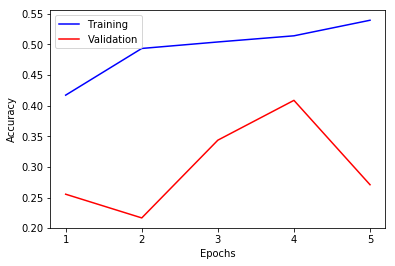

In [13]:
plt.plot(range(1,epochs+1), history.history['accuracy'],'b')
plt.plot(range(1,epochs+1),history.history['val_accuracy'],'r')
plt.xlabel('Epochs')
plt.xticks([1,2,3,4,5])
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.savefig('colorAccVEpoch.png')

In [11]:
from sklearn.metrics import confusion_matrix

guess = model.predict_generator(test_gen)
truth = test_gen.classes

matrix = confusion_matrix(truth,guess.argmax(axis=1))
print(matrix)

[[11  6 24  1  1  6]
 [13  7 20  4  5 10]
 [15 10 28  2  2  6]
 [ 9 10 25  1  1  5]
 [ 9 16 26  1  4 11]
 [ 9  5 23  3  5  4]]


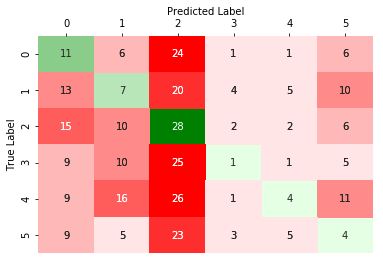

In [12]:
import seaborn as sn
import pandas as pd

# Plot the confusion matrix as a heatmap

sn.heatmap(matrix,cmap=sn.light_palette("green"),annot=True,cbar=False)
sn.heatmap(matrix,mask = np.eye(6),cmap=sn.light_palette("red"),annot=True,cbar=False)
plt.ylabel('True Label')
ax = plt.gca()
plt.xlabel('Predicted Label')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.savefig('colorConfuse.png')
